In [226]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [227]:
f = lambda x: 1.35**x

xlim = 20
n_samples = 100         # astype('f') required for TensorFlow to prevent "TypeError: Input 'b' of 'MatMul'
truex = np.linspace(-xlim, xlim, n_samples).astype('f')  #  Op has type float32 that does not match type float64
truey = [f(_) for _ in truex]
rands = np.random.randn(n_samples).astype('f')          #  of argument 'a'." error

# this is a problem because consecutive batches aren't sampled similarly, so the cost doesn't converge
# in each consecutive batch
#randy = [exp(v + rands[i]) for i, v in enumerate(truex)]
shufx = np.copy(truex)
np.random.shuffle(shufx)
shufrandy = [f(v + rands[i]) for i, v in enumerate(shufx)]
shufrande = [f(v + rands[i]) - f(v) for i, v in enumerate(shufx)]

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix', 'text.usetex': False})

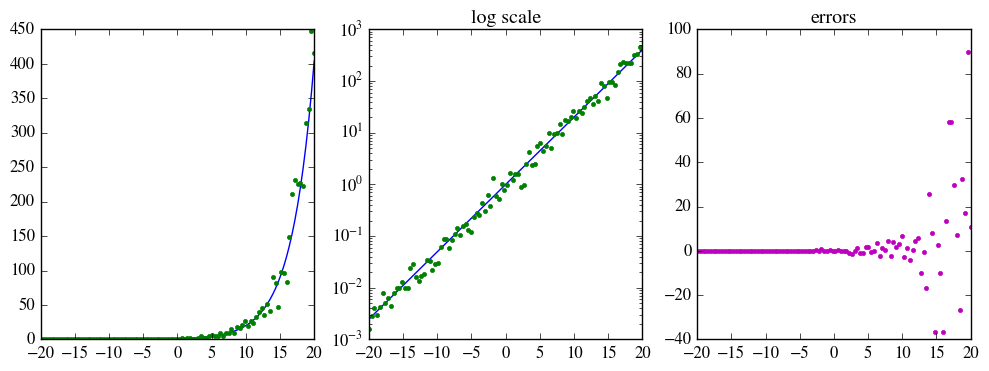

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0].plot(shufx, shufrandy, 'g.')

ax[1].set_title('log scale')
ax[1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[1].plot(shufx, shufrandy, 'g.')
ax[1].set_yscale("log")

ax[2].set_title('errors')
ax[2].plot(shufx, shufrande, 'm.');

In [229]:
import tensorflow as tf

In [230]:
# Parameters
learning_rate = 0.05
training_epochs = 250
batch_size = 10
display_step = training_epochs / 10

# Network Parameters
n_hidden_1 = 7 # 1st layer number of features (see note below)
n_hidden_2 = n_hidden_1 # 3 # 2nd layer number of features
n_input = 1 # value of X
n_output = 1 # value of Y

  While a more common `phi_activation_fn` is the sigmoid function, the particular form of `phi_activation_fn` is not that important as long as it has 'good' coverage of all the degrees in its Taylor series. [http://theory.stanford.edu/~valiant/papers/andoni14.pdf]

In [231]:
# Create model (https://wookayin.github.io/TensorflowKR-2016-talk-debugging/#15)
def multilayer_perceptron(xinput, weights, biases, net={}):
    
    # Hidden layer with RELU activation (FWC - changed from 'relu' to 'sigmoid')
    # On 'contrib' - https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/README.md
    net['layer_1'] = tf.contrib.layers.fully_connected(xinput, n_hidden_1, activation_fn=tf.nn.relu)
    #net['layer_1'] = tf.nn.relu(tf.matmul(xinput, weights['h1']) + biases['b1']) # FWC    
    #layer_1 = tf.nn.relu(tf.add(tf.matmul(xinput, weights['h1']), biases['b1']))
    
    # Hidden layer with RELU activation (FWC - changed from 'relu' to 'sigmoid')
    #net['layer_2'] = tf.nn.relu(tf.add(tf.matmul(net['layer_1'], weights['h2']), biases['b2']))
    
    # Output layer with linear activation
    #out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    net['out_layer'] = tf.contrib.layers.fully_connected(net['layer_1'], n_output, activation_fn=None) # `=None` => linear
    
    # a fully interconnected network is a form of reuse/replication, just like RNNs.
    # why else is there a reason to have full connectivity?
    # given this, can a fully connected network approximate an RNN?  perhaps by having some
    #   fast- and some slow-moving nodes?
    
    return net['out_layer']

In [232]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

# Construct model w/ input/output placeholders
# FWC - None is for the batch size? (yes, see 34240703 link below: "the first
#   dimension is treated as the batch")  and then 1 for the actual input shape
x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])
net = {}
y_pred = multilayer_perceptron(x, weights, biases, net=net)

# Define loss and optimizer (https://www.tensorflow.org/api_docs/python/nn/)
# FWC - for heteroskedastic functions, first learn the shape of the error/cost/loss, then learn the actual
# function of interest with a cost function that is normalized for the heteroskedasticity of the data
# similar to this: https://en.wikipedia.org/wiki/AdaBoost
#cost = (y - y_pred)**2
cost = tf.reduce_sum(tf.pow(y_pred-y, 2))#/(2*n_samples)
#cost = tf.reduce_sum(tf.abs(y_pred-y)) # FWC
#cost = tf.reduce_sum(tf.sqrt(tf.abs(y_pred-y))) # FWC
#cost = tf.reduce_sum(tf.log(tf.pow(y_pred-y, 2))) # FWC
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_pred, y)) # http://stackoverflow.com/questions/34240703/difference-between-tensorflow-tf-nn-softmax-and-tf-nn-softmax-cross-entropy-with

# is there a cost function that will simultaneously normalize and minimize the errors?
# any global normalization, like softmax, is going to be expensive (assuming it's not impossible).
# AdaBoost with normalization

# GradientDescentOptimizer - https://www.tensorflow.org/api_docs/python/train/optimizers#GradientDescentOptimizer.__init__
# RMSProp - https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard6/tf.train.RMSPropOptimizer.md
# overview: http://sebastianruder.com/optimizing-gradient-descent/
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) # FWC
#optimizer = tf.train.RMSPropOptimizer(learning_rate, momentum=0.1).minimize(cost) # FWC (https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard6/tf.train.RMSPropOptimizer.md)


# Initializing the variables
init = tf.global_variables_initializer() # FWC formerly deprecated `tf.initialize_all_variables()`

"if you could ask a network to summarize a photo, you could perhaps also ask it to summarize a sentence." [http://www.nytimes.com/2016/12/14/magazine/the-great-ai-awakening.html?_r=0]
FWC -  so why not ask it to summarize a (exponential) function?  Or summarize a tv program by removing all of the duplicated/uninteresting parts

In [233]:
pys = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #print("h1=", sess.run(weights['h1']), "b1=", sess.run(biases['b1']), "ho=", sess.run(weights['out']), "bo=", sess.run(biases['out']), '\n')

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            bbegin = i * batch_size
            bend = min((i+1) * batch_size, n_samples)
            #print('bbegin={} bend={}'.format(bbegin, bend))
            batch_x = np.array(shufx[bbegin:bend]).reshape((bend-bbegin, 1))
            batch_y = np.array(shufrandy[bbegin:bend]).reshape((bend-bbegin, 1))
            #print('shapex={} shapey={}'.format(batch_x.shape, batch_y.shape))

            # Run optimization op (backprop) and cost op (to get loss value)
            # (FWC - the 'x' and 'y' here appear to map to the placeholders above)
            # "The most important method in Tensorflow --- where every computation is performed!
            #   tf.Session.run(fetches, feed_dict) runs the operations and evaluates in fetches,
            #   subsituting the values (placeholders) in feed_dict for the corresponding input values."
            loss_val, c, out = sess.run([optimizer, cost, net['out_layer']], feed_dict={x: batch_x, y: batch_y})
            
            # Compute average loss
            avg_cost += c / total_batch
            
            if epoch == training_epochs-1: # or epoch < 1:
                #print("c=", c, "\nl1=", l1, "\nout=", out)#, "ho=", sess.run(weights['out']), "bo=", sess.run(biases['out']))
#                print('Loss(x0,y0) = %.3f' % sess.run(cost, {x: batch_x[0].reshape(1, 1), y: batch_y[0].reshape(1, 1)}))
#                print('Loss(0,1) = %.3f' % sess.run(cost, {x: [[0]], y: [[1]]}))
#                print('pred_y(x0) = %.3f' % sess.run(y_pred, {x: batch_x[0].reshape(1, 1)}))
#                print('pred_y(0) = %.3f' % sess.run(y_pred, {x: [[0]]}))
                #print('bias      = %.3f' % sess.run(bias))

                if bbegin == 0:
                    batchout = []
                    for i in range(bend - bbegin):
                        c, py = sess.run([cost, y_pred], feed_dict={x: batch_x[i].reshape(1, 1), y: batch_y[i].reshape(1, 1)})
                        batchout.append((batch_x[i,0], batch_y[i,0], py[0,0], f(batch_x[i,0]), c))
                        #print('Loss({}, x={:.2f}, y={:.2f}, py={:.2f}, ty={:.2f}) = {:.2f}'.format(i + bbegin, batch_x[i,0], batch_y[i,0], py[0,0], f(batch_x[i,0]), c))
                    for bo in sorted(batchout):
                        print('  Loss(x={:.2f}, y={:.2f}, py={:.2f}, ty={:.2f}) = {:.2f}'.format(*bo))
                    
            # save final predictions for plotting
            if epoch == training_epochs-1:
                for py in out:
                    pys.append(py)
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            
    print("Optimization Finished!")
    

    # Test model
    #correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #print "Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels})

Epoch: 0001 cost= 86289.739257812
Epoch: 0026 cost= 22918.731689453
Epoch: 0051 cost= 14638.219348145
Epoch: 0076 cost= 9929.403289795
Epoch: 0101 cost= 8214.313522720
Epoch: 0126 cost= 6926.780096436
Epoch: 0151 cost= 6082.971163940
Epoch: 0176 cost= 5267.510021973
Epoch: 0201 cost= 4794.149362183
Epoch: 0226 cost= 4128.703289795
  Loss(x=-20.00, y=0.00, py=6.52, ty=0.00) = 42.50
  Loss(x=-15.96, y=0.01, py=5.43, ty=0.01) = 29.33
  Loss(x=-12.73, y=0.01, py=4.55, ty=0.02) = 20.57
  Loss(x=-11.52, y=0.03, py=4.22, ty=0.03) = 17.52
  Loss(x=-9.49, y=0.06, py=3.67, ty=0.06) = 13.04
  Loss(x=-7.07, y=0.15, py=3.01, ty=0.12) = 8.24
  Loss(x=-0.20, y=0.79, py=1.15, ty=0.94) = 0.13
  Loss(x=4.65, y=5.59, py=2.87, ty=4.03) = 7.41
  Loss(x=5.86, y=5.65, py=4.15, ty=5.80) = 2.28
  Loss(x=18.79, y=313.60, py=287.38, ty=280.99) = 687.51
Optimization Finished!


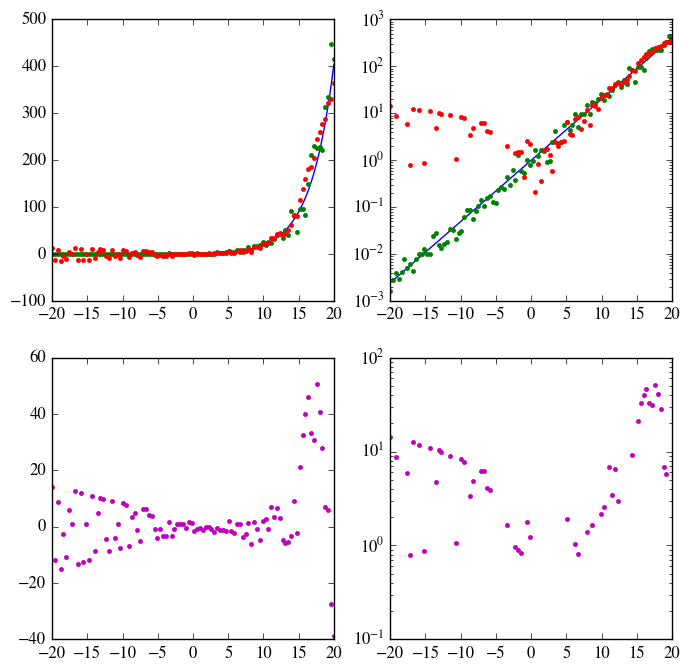

In [234]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0][0].plot(truex, truey)
#ax[0].set_xlim(-xlim/4, xlim/4); ax[0].set_ylim(0, xlim*5); ax[0].grid(True)
ax[0][0].plot(shufx, shufrandy, 'g.')
ax[0][0].plot(shufx, pys, 'r.')

ax[0][1].plot(truex, truey)
#ax[1].grid(True) #ax[1].set_xlim(-xlim/4, xlim/4); ax[1].set_ylim(0, xlim*5); 
ax[0][1].plot(shufx, shufrandy, 'g.')
ax[0][1].plot(shufx, pys, 'r.')
ax[0][1].set_yscale("log")

# errors
pes = [py - f(shufx[i]) for i, py in enumerate(pys)]
ax[1][0].plot(shufx, pes, 'm.');
ax[1][1].plot(shufx, pes, 'm.');
ax[1][1].set_yscale("log")